<a href="https://colab.research.google.com/github/snghynn/summ/blob/main/concept_CNN2_EuroSAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 4.4 위성 이미지 분류
### 4-1 텐서플로 데이터셋 로드
- EuroSAT 데이터셋: 인공위성에서 지표면을 촬영한 이미지와 토지이용분류값이 정리되어 있는 데이터셋
- 총 27,000장의 위성 사진과 10개의 토지이용분류값이 매칭되어 제공됨

In [ ]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

# Tensorflow Datasets 활용
import tensorflow_datasets as tfds

In [ ]:
# EuroSAT 위성 사진 데이터셋 로드
(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                       shuffle_files=True, as_supervised=True, with_info=True, data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /content/drive/MyDrive/ESAA/OB/data/eurosat/rgb/2.0.0.incompleteRRESB0/eurosat-train.tfrecord*...:  …

Dataset eurosat downloaded and prepared to /content/drive/MyDrive/ESAA/OB/data/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
# 메타 데이터 확인: JPEG 이미지로 인코딩한 RGB 데이터셋
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir=PosixGPath('/tmp/tmpvqmw1zegtfds'),
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('ima

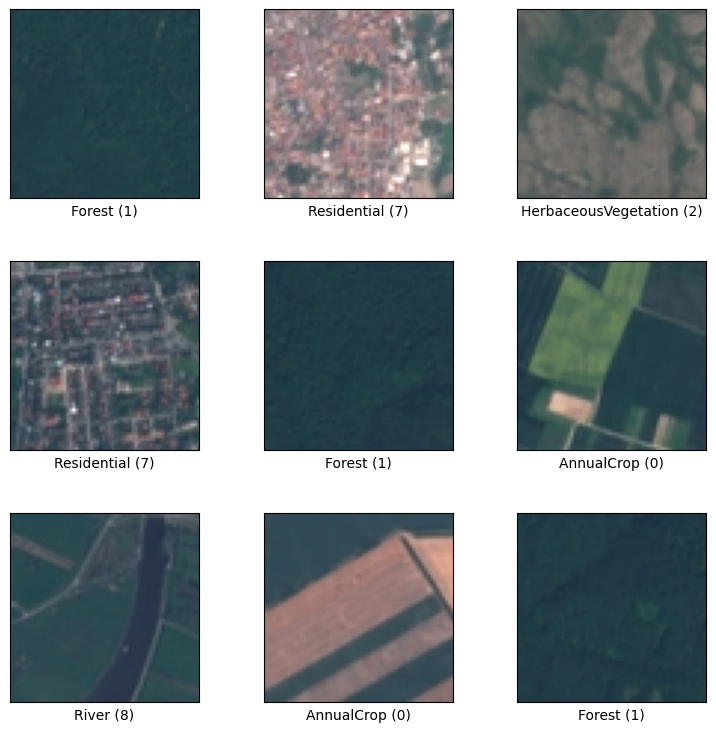

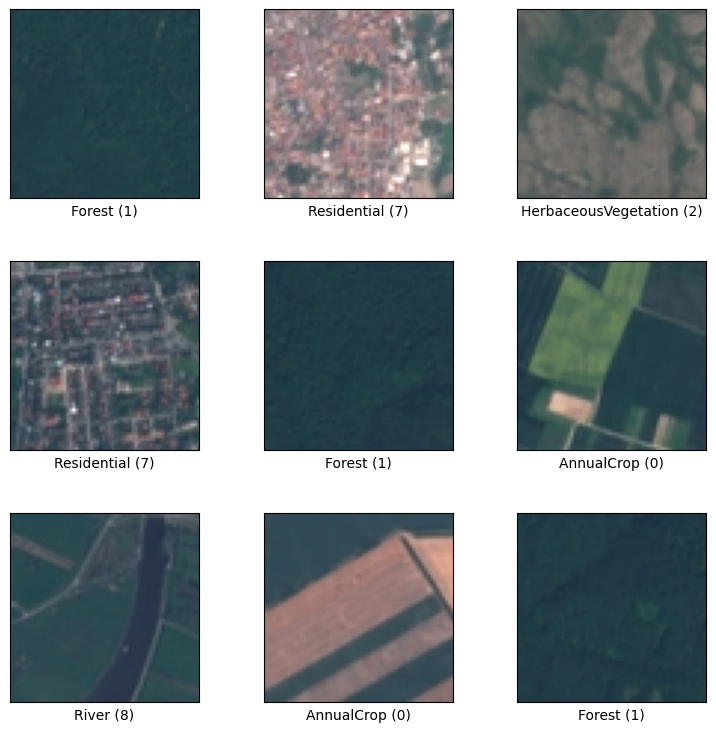

In [ ]:
# show_examples(): 샘플 이미지를 메타 정보인 분류 레이블과 함께 화면에 출력
# 데이터 확인
tfds.show_examples(train_ds, info)

image  label
0  [[[56, 84, 121], [56, 85, 119], [67, 94, 124],...      5
1  [[[102, 105, 112], [105, 104, 110], [116, 107,...      7
2  [[[82, 98, 97], [83, 97, 97], [86, 97, 99], [9...      0
3  [[[56, 72, 87], [56, 72, 87], [52, 70, 82], [5...      1
4  [[[219, 154, 126], [218, 153, 125], [220, 154,...      0
5  [[[69, 83, 84], [67, 83, 83], [65, 80, 85], [6...      2
6  [[[28, 52, 76], [28, 52, 76], [31, 51, 75], [3...      9
7  [[[45, 75, 77], [46, 74, 78], [49, 69, 78], [6...      8
8  [[[135, 127, 124], [135, 127, 124], [132, 127,...      2
9  [[[40, 55, 74], [40, 55, 74], [41, 56, 75], [3...      9
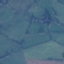
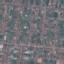
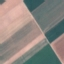
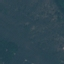
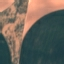
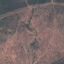
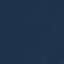
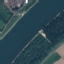
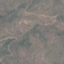
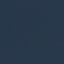

In [ ]:
# as_dataframe(): 샘플 이미지 출력
tfds.as_dataframe(valid_ds.take(10), info)

In [ ]:
# 목표 클래스의 개수
NUM_CLASSES = info.features["label"].num_classes
print(NUM_CLASSES)

10


> 토지이용분류에 해당하는 정답 클래스 개수: 10개

0은 경지(AnnualCrop),..., 9는 바다/호수(SeaLake)

In [ ]:
# 숫자 레이블 활용해 문자열 메타 데이터로 변환
print(info.features["label"].int2str(6))

PermanentCrop


### 4-2 데이터 전처리
- 텐서플로 데이터셋 사용 시 데이터 전처리 과정이 쉬움

< `preprocess_data()` 함수 정의 >
- 텐서플로 연산은 float32 숫자 값을 사용
: `cast()` 사용해 자료형 -> float32
- 입력 이미지는 0~255 범위의 픽셀 값을 가짐
: 255로 나누어 정규화

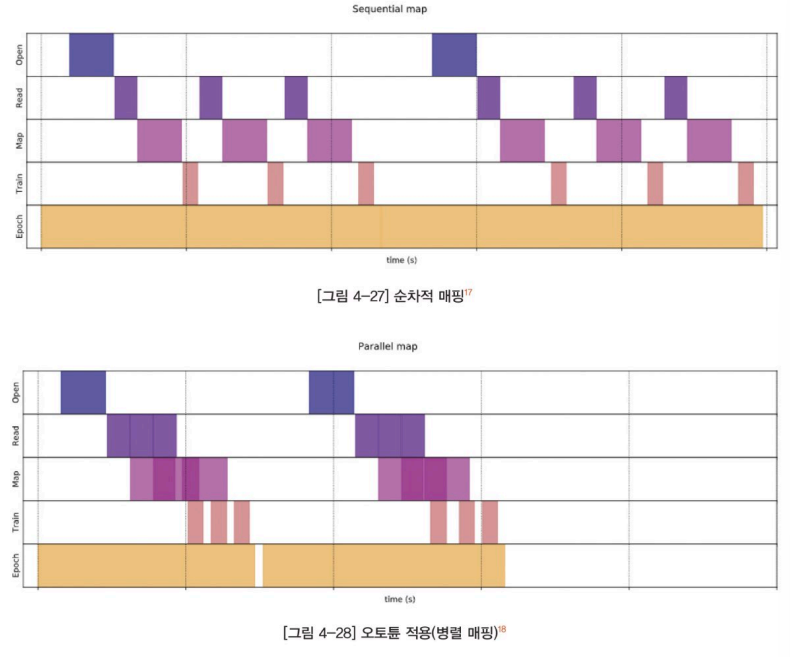

>- 오토튠 적용X: 데이터를 읽어서 매핑하고 훈련하는 과정을 순차적으로 처리 -> 시간 오래 걸림
- 오토튠 적용O: 하드웨어 리소스를 병렬로 매핑하여 처리 -> 짧은 시간에 처리 가능


- 정규화 변환 마친 데이터셋에 `shuffle()` 적용: 훈련 데이터셋에서 미니 배치를 생성할 때 입력 순서에 무작위성 부여
- `BIFFER_SIZE=1000`, `BATCH_SIZE=64` : 처음 1000개의 데이터를 가져와 섞고, 64개의 데이터를 랜덤하게 선택해 하나의 배치를 구성
- `prefetch()`: 모델이 훈련을 진행하는 동안 다음에 입력할 데이터를 불러와 미리 전처리를 하도록 -> 병렬 처리 통해 모델 훈련 시간 단축

In [ ]:
# 데이터 전처리 파이프라인
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
  image = tf.cast(image, tf.float32) / 255.  # 0~1 정규화, float32 변환
  return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

### 4-3 모델 훈련 및 검증
< Sequential API >
- 배치 정규화, 합성곱, 풀링 레이어로 구성된 유닛을 2개 연결
- Dense 레이어와 Droupout으로 구성된 최종 분류기를 가짐



In [ ]:
# Sequential API를 사용하여 샘플 모델 생성
def build_model():
  model = tf.keras.Sequential([
      # Convolution층
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2, 2)),

      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2, 2)),

      # Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
  ])
  return model

model = build_model()

In [ ]:
## 예측 클래스가 10개인 다중 분류 문제에 맞게 손실함수와 평가지표 설정하고, 모델을 50 epoch 훈련시킴
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_data, validation_data=valid_data, epochs=10)

Epoch 1/10
338/338 [==============================] - 234s 682ms/step - loss: 1.5242 - accuracy: 0.4517 - val_loss: 1.2686 - val_accuracy: 0.5713
Epoch 2/10
338/338 [==============================] - 179s 530ms/step - loss: 1.1937 - accuracy: 0.5646 - val_loss: 0.9257 - val_accuracy: 0.6730
Epoch 3/10
338/338 [==============================] - 171s 506ms/step - loss: 1.0441 - accuracy: 0.6253 - val_loss: 0.7391 - val_accuracy: 0.7663
Epoch 4/10
338/338 [==============================] - 171s 505ms/step - loss: 0.9380 - accuracy: 0.6615 - val_loss: 0.6603 - val_accuracy: 0.7737
Epoch 5/10
338/338 [==============================] - 171s 505ms/step - loss: 0.8431 - accuracy: 0.7025 - val_loss: 0.6263 - val_accuracy: 0.7896
Epoch 6/10
338/338 [==============================] - 170s 503ms/step - loss: 0.7836 - accuracy: 0.7222 - val_loss: 0.5299 - val_accuracy: 0.8313
Epoch 7/10
338/338 [==============================] - 170s 504ms/step - loss: 0.7398 - accuracy: 0.7405 - val_loss: 0.5530 -

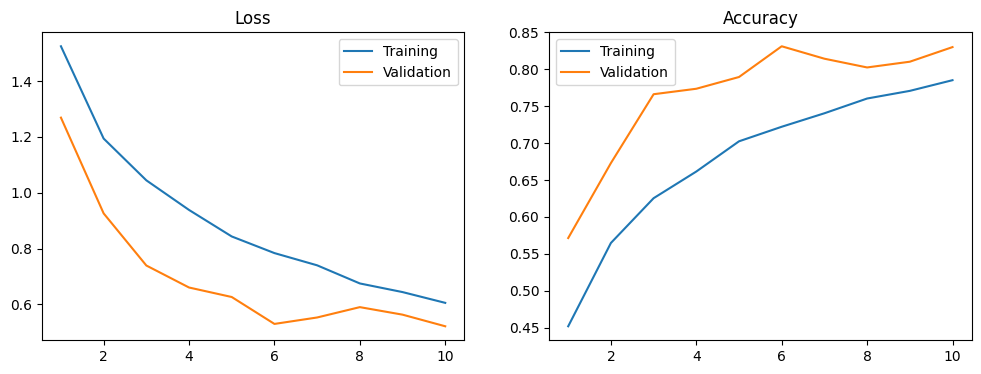

In [ ]:
# 손실함수, 정확도 그래프 그리기
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 10)

### 4-4 데이터 증강(Data Augmentation)
- 앞서 과대적합을 해소하는 기법인 배치 정규화, Droupout 등을 적용했음에도 과대적합이 발생
- 데이터 증강기법: 이미지 분류 문제에서 과대적합을 해소하고, 모델의 일반화된 Robust한 성능을 확보하는 기법
- 이미지 데이터에 여러 변형을 주어 훈련 데이터의 다양성을 확보하는 방식
- 모델이 새로운 데이터에 대한 예측력을 강화하도록 하는 개념

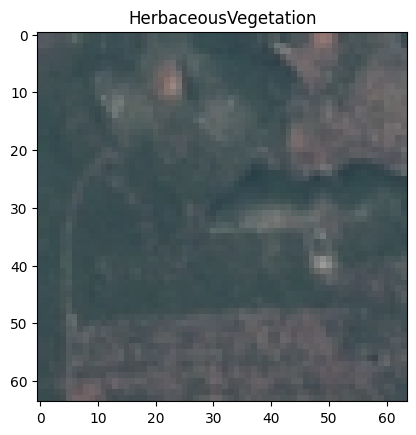

In [ ]:
# EuroSAT 데이터셋 중에서 하나의 샘플 이미지를 선택하여 시각화
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label));

In [ ]:
# 데이터 증강 전후를 비교하는 시각화 함수 정의
def plot_augmentation(original, augmented):

  fig, axes = plt.subplots(1, 2, figsize=(12, 4))

  axes[0].imshow(original)
  axes[0].set_title('Original')

  axes[1].imshow(augmented)
  axes[1].set_title('Augmented')

  plt.show()

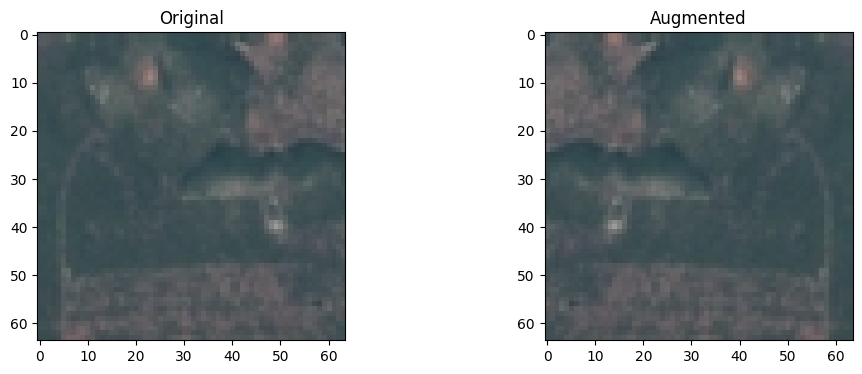

In [ ]:
# flip_left_right(): tf.image 모듈의 이미지를 좌우 방향으로 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

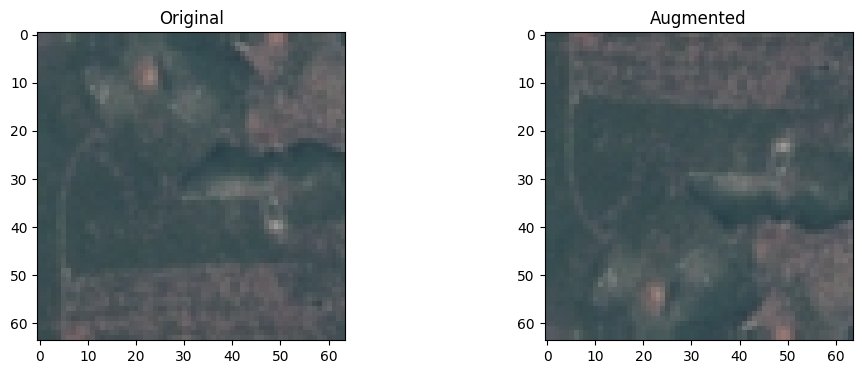

In [ ]:
# flip_up_down(): 이미지를 상하 방향으로 뒤집기
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

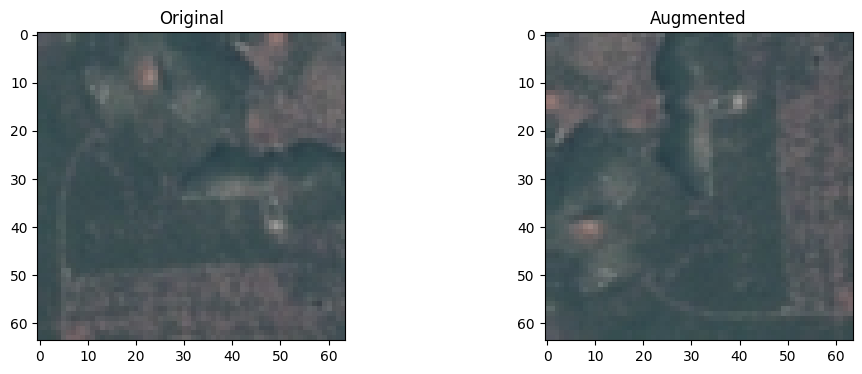

In [ ]:
# rot90(): 이미지를 반시계 방향으로 90도 회전
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

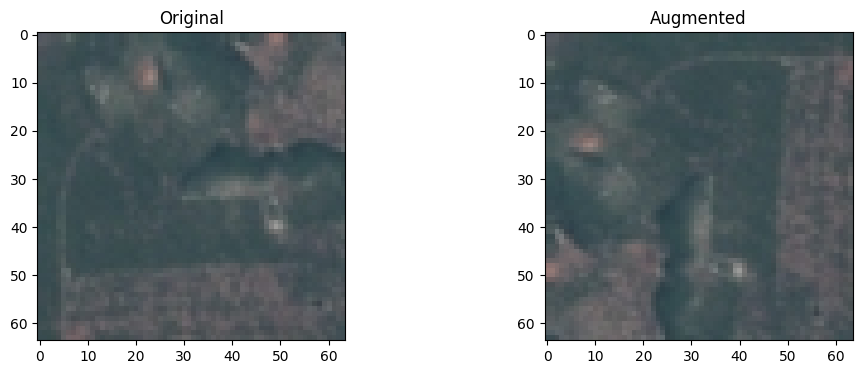

In [ ]:
# transpose(): 이미지 텐서 행렬의 행과 열의 위치를 바꿔줌(행렬의 도치)
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

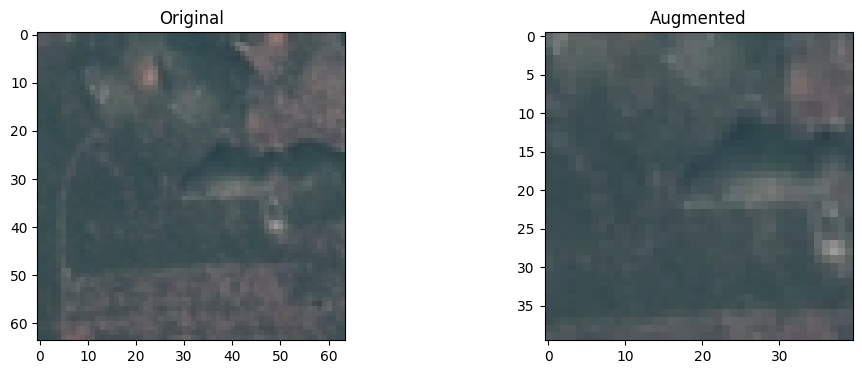

In [ ]:
# central_crop(): 이미지의 중심에서 일정 부분을 잘라냄
# 이미지 자르기 1
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

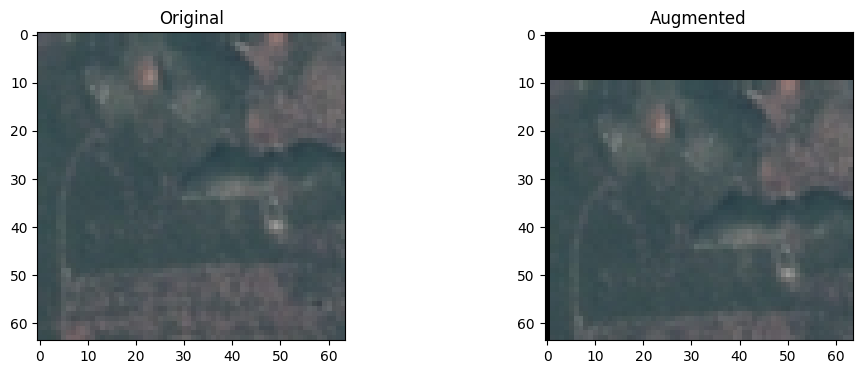

In [ ]:
# resize_with_crop_or_pad(): 원본 이미지의 크기를 키움
# random_crop(): 이미지를 원본 크기와 같게 자르면 원본 이미지가 상하좌우 랜덤한 방향으로 shift
# 이미지 자르기 2
img = tf.image.resize_with_crop_or_pad(image, 64+20, 64+20)  # 사이즈 키우기
crop2 = tf.image.random_crop(img, size=[64, 64, 3])
plot_augmentation(image, crop2)

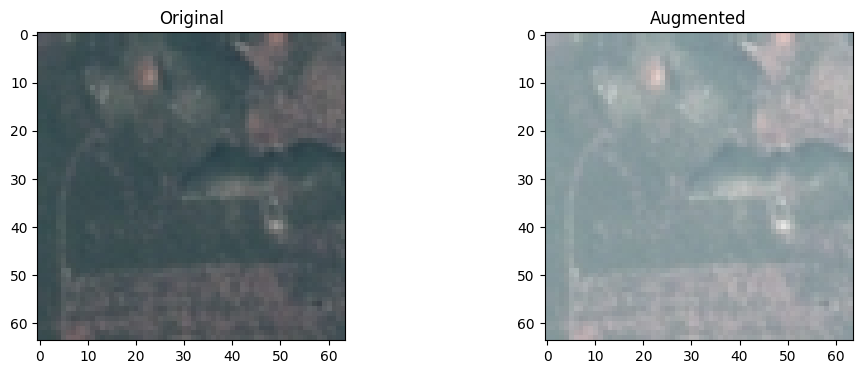

In [ ]:
# 이미지 밝기 조정
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

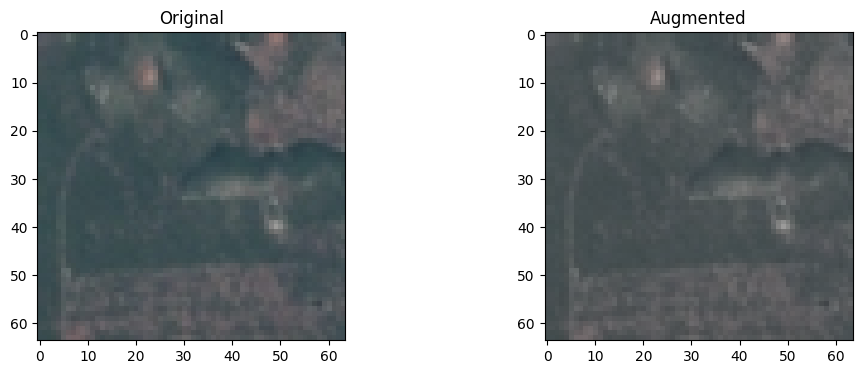

In [ ]:
# 이미지 채도 변경
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

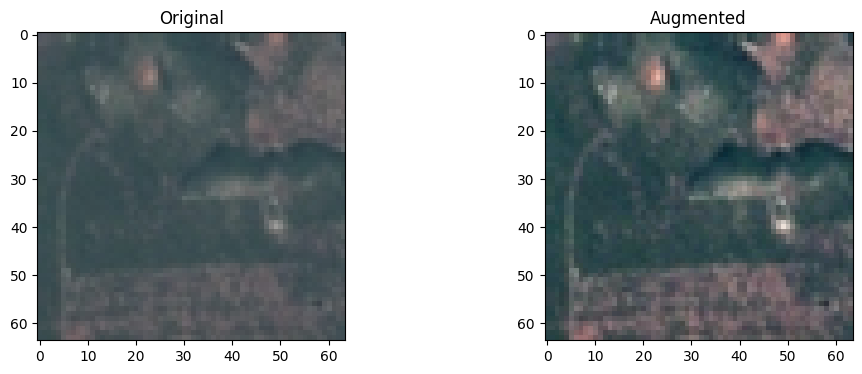

In [ ]:
# 이미지 대비 조정
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

In [ ]:
# data_augmentation() 정의: 데이터 증강 및 전처리 수행
# 이미지 증강 전처리
def data_augmentation(image, label):

  image = tf.image.random_flip_left_right(image)  # 좌우 반전
  image = tf.image.random_flip_up_down(image)  # 상하 반전
  image = tf.image.random_brightness(image, max_delta=0.3)  # 밝기 변화
  image = tf.image.random_crop(image, size=[64, 64, 3])

  image = tf.cast(image, tf.float32) / 255.  # 0~1 정규화

  return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
aug_history = aug_model.fit(train_aug, validation_data=valid_aug, epochs=10)

Epoch 1/10
338/338 [==============================] - 179s 523ms/step - loss: 1.9388 - accuracy: 0.2849 - val_loss: 1.6621 - val_accuracy: 0.3511
Epoch 2/10
338/338 [==============================] - 177s 523ms/step - loss: 1.6491 - accuracy: 0.3544 - val_loss: 1.4781 - val_accuracy: 0.4557
Epoch 3/10
338/338 [==============================] - 175s 517ms/step - loss: 1.5189 - accuracy: 0.4045 - val_loss: 1.2916 - val_accuracy: 0.5111
Epoch 4/10
338/338 [==============================] - 174s 513ms/step - loss: 1.4346 - accuracy: 0.4474 - val_loss: 1.2309 - val_accuracy: 0.5298
Epoch 5/10
338/338 [==============================] - 173s 511ms/step - loss: 1.3414 - accuracy: 0.4867 - val_loss: 1.1040 - val_accuracy: 0.6109
Epoch 6/10
338/338 [==============================] - 173s 511ms/step - loss: 1.2916 - accuracy: 0.5095 - val_loss: 1.0823 - val_accuracy: 0.6122
Epoch 7/10
338/338 [==============================] - 170s 504ms/step - loss: 1.2234 - accuracy: 0.5428 - val_loss: 0.9740 -

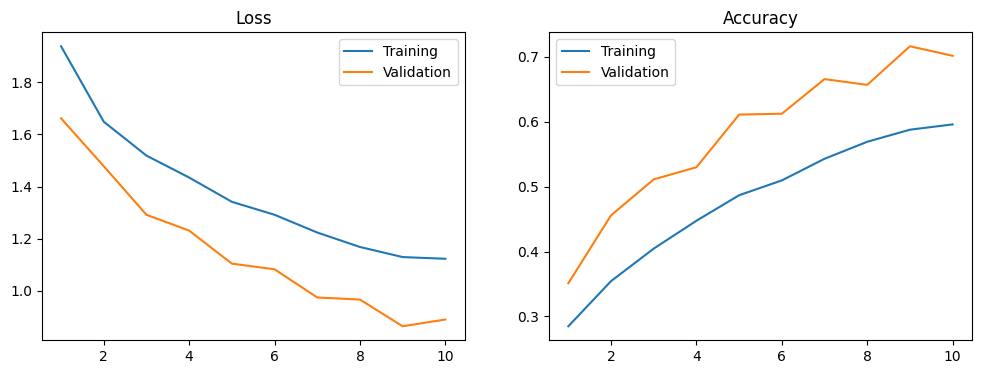

In [ ]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(aug_history, 10)

### 4-5 ResNet 사전 학습 모델
- 전이 학습(Transfer Learning): 딥러닝 모델의 구조와 가중치를 그대로 가져오고, 모델의 끝단에 위치하는 top층에 위성 이미지를 분류할 수 있는 최종 분류기를 추가하는 방식으로 모델 구성
- ResNet50V2
- input_shape: (64,64,3)
- ResNet 모델의 입력 크기 (224, 224,3) -> (64,64,3)
- 분류하려는 클래스 레이블의 개수(10)를 classes 속성에 지정
- include_top = False: 기존 ResNet모델의 Top층은 이미지넷 경진 대회의 맞는 분류기이므로 False 지정

94668760/94668760 [==============================] - 1s 0us/step


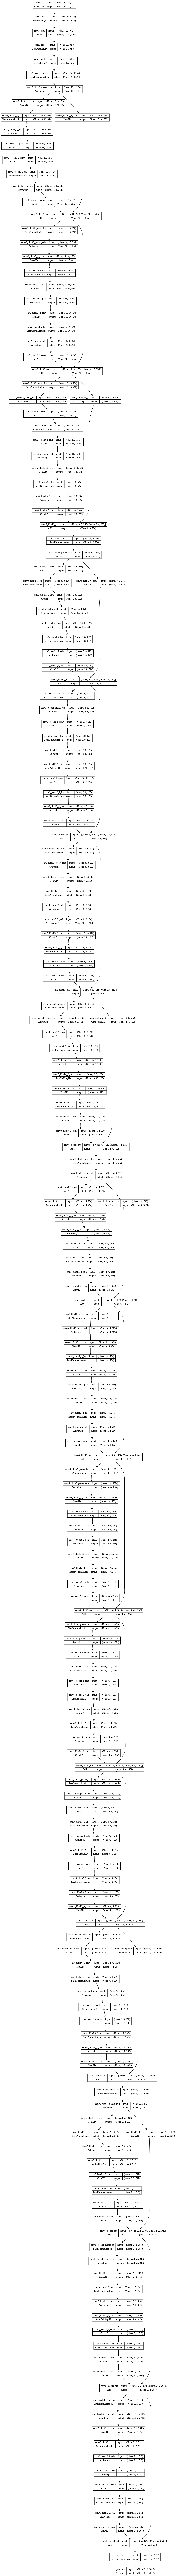

In [ ]:
# Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False,
                               weights='imagenet',
                               input_shape=[64, 64, 3])

# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

# 모델 구조 시각화
from tensorflow.keras.utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

In [ ]:
# Top 층에 Classifier 추가

def build_trainsfer_classifier():

  model = tf.keras.Sequential([

      # Pre-trained Base
      pre_trained_base,
      # Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])

  return model

# 모델 구조
tc_model = build_trainsfer_classifier()
tc_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 10)               